# Dimensionality Reduction
#### Roles and Buckets

In [57]:
!pip install mxnet

In [58]:
# sagemaker libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

# pandas and np
import numpy as np
import pandas as pd

import os

In [59]:
session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::305472246504:role/service-role/AmazonSageMaker-ExecutionRole-20210617T231874


In [60]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-1-305472246504



#### Define a PCA Model
* role: The IAM role, which was specified, above.
* train_instance_count: The number of training instances (typically, 1).
* train_instance_type: The type of SageMaker instance for training.
* num_components: An integer that defines the number of PCA components to produce.
* sagemaker_session: The session used to train on SageMaker.

In [61]:
# define location to store model artifacts
prefix = 'starbucks'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-305472246504/starbucks/


In [62]:
data_scaled.shape[1]

17

In [63]:
# define a PCA model
from sagemaker import PCA

data_scaled = pd.read_csv('saved_progress/scaled_dataset.csv')
data_scaled.drop(columns=['Unnamed: 0'], inplace=True)

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS = data_scaled.shape[1] - 1

pca_starbucks = PCA(role=role,
             instance_count=1,
             instance_type='ml.p2.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

#### Convert data into a RecordSet format¶
Next, prepare the data for a built-in model by converting the DataFrame to a numpy array of float values.

The record_set function in the SageMaker PCA model converts a numpy array into a RecordSet format that is the required format for the training input data. This is a requirement for all of SageMaker's built-in models. The use of this data type is one of the reasons that allows training of models within Amazon SageMaker to perform faster, especially for large datasets.

In [30]:
# convert df to np array
train_data_np = data_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_starbucks.record_set(train_data_np)

#### Train the model

In [31]:
%%time

# train the PCA mode on the formatted data
pca_starbucks.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-06-18 05:52:03 Starting - Starting the training job...
2021-06-18 05:52:30 Starting - Launching requested ML instancesProfilerReport-1623995523: InProgress
...
2021-06-18 05:53:03 Starting - Preparing the instances for training............
2021-06-18 05:55:04 Downloading - Downloading input data...
2021-06-18 05:55:31 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/18/2021 05:55:46 INFO 140045461944128] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[06/18/2021 05:55:46 INFO 140045461944128] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': '17', 'num_components'

In [37]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2021-06-18-05-52-03-430'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

starbucks/pca-2021-06-18-05-52-03-430/output/model.tar.gz


2304

In [38]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[  8.429521  26.027431  26.81646   36.325542  49.304764  60.88973
  69.86713  117.247246 141.33946  176.21779  205.10966  210.07256
 232.26009  275.1433   312.74768  460.00626 ]
<NDArray 16 @cpu(0)>, 'v': 
[[ 3.18557839e-03 -7.81635791e-02  7.37826107e-03  1.40297518e-03
  -1.12440594e-01  9.88959193e-01 -2.08910443e-02  1.02859633e-02
  -8.66883621e-03  5.61253866e-03 -2.89129708e-02  2.43291054e-02
  -7.57212471e-03  2.10041888e-02  2.93655996e-03 -2.35308390e-02]
 [-8.78858939e-02 -9.89152968e-01 -6.20757565e-02  9.91216861e-03
  -2.15466525e-02 -7.78500810e-02 -1.01529974e-02 -4.63129254e-03
   2.67041917e-03 -2.45285942e-03  3.01984232e-02 -2.09360085e-02
   7.42787262e-03 -9.99702793e-03  1.75119052e-03  1.87980253e-02]
 [-2.28298791e-02  1.39766140e-02  9.04494673e-02  8.38360250e-01
  -9.33418646e-02  5.99262057e-05 -2.11296249e-02 -2.47032389e-01
  -1.42061897e-02  1.79974988e-01 -2.54638307e-02  5.52906953e-02
  -7.09493160e-02 -1.94553122e-01 -1.72387194e-02  3.722293

#### PCA Model Attributes
Three types of model attributes are contained within the PCA model.

**mean**: The mean that was subtracted from a component in order to center it.

**v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).

**s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

We are only interested in v and s.

In [39]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

#### Data Variance
Our current PCA model creates 33 principal components, but when we create new dimensionality-reduced training data, we'll only select a few, top n components to use. To decide how many top components to include, it's helpful to look at how much data variance the components capture.



When we select the top n components to use in a new data model, we'll typically want to include enough components to capture about 80-90% of the original data variance. In this project, we are looking at generalizing over a lot of data and we'll aim for about 85% coverage.

Note: The top principal components, with the largest s values, are actually at the end of the s DataFrame. Let's print out the s values for the top n, principal components.

In [40]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  

# print a selection of s
print(s.iloc[start_idx:, :])

             0
11  210.072556
12  232.260086
13  275.143311
14  312.747681
15  460.006256


In [41]:

def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components 
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [42]:
# test cell
n_top_components = 5 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.80019265


#### Component Makeup
We can now examine the makeup of each PCA component based on **the weightings of the original features that are included in the component**. The following code shows the feature-level makeup of the first component.

Note that the components are again ordered from smallest to largest and so I am getting the correct rows by calling N_COMPONENTS-1 to get the top, 1, component.

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns 

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

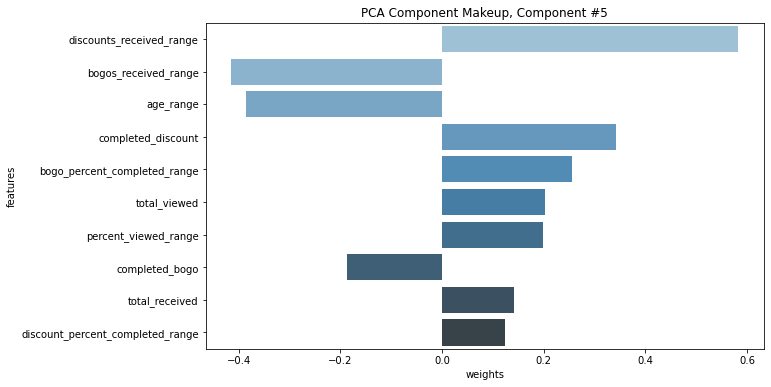

In [47]:
# display makeup of first component
num = 5
display_component(v, data_scaled.columns.values, component_num=num, n_weights=10)

#### Deploying the PCA Model
We can now deploy this model and use it to make "predictions". Instead of seeing what happens with some test data, we'll actually want to pass our training data into the deployed endpoint to create principal components for each data point.

In [48]:
%%time
# this takes a little while, around 8mins
pca_predictor = pca_starbucks.deploy(initial_instance_count=1, 
                              instance_type='ml.p2.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------!CPU times: user 258 ms, sys: 14.7 ms, total: 273 ms
Wall time: 6min 32s


In [49]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

In [50]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: -0.04098334163427353
      values: -0.33758804202079773
      values: -1.5152660608291626
      values: -0.3862875699996948
      values: -0.16776907444000244
      values: -0.5303946137428284
      values: 0.20309117436408997
      values: 0.17287135124206543
      values: 0.4031820297241211
      values: 0.3596435785293579
      values: -2.0268912315368652
      values: -3.3388209342956543
      values: 7.19050931930542
      values: -4.023331165313721
      values: -1.9289969205856323
      values: -2.620175838470459
    }
  }
}



In [51]:

def create_transformed_df(train_pca, data_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    data_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        data_transformed = data_transformed.append([list(components)])

    # index by county, just like counties_scaled
    data_transformed.index = data_scaled.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    data_transformed = data_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return data_transformed.iloc[:, ::-1]

In [52]:
# specify top n
top_n = 5

# call your function and create a new dataframe
data_transformed = create_transformed_df(train_pca, data_scaled, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5']
data_transformed.columns=PCA_list 

# print result
data_transformed.head()

,c_1,c_2,c_3,c_4,c_5
0,-2.620176,-1.928997,-4.023331,7.190509,-3.338821
1,4.298525,2.480468,2.814970,0.869880,-3.051544
2,-0.090560,-2.853034,-1.224657,0.493026,1.071919
3,5.288128,-3.513768,-0.159936,-1.837879,1.218396
4,-2.118860,-2.629998,-1.038443,0.802769,0.593156


In [54]:

# Save PCA dataset
data_transformed.to_csv('saved_progress/pca_scores.csv')

In [55]:
# Delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


#### Metrics
**Eblow method**
Inertia measures how well a data set is clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance and summing these squares into a cluster.

A good model is one with low inertia AND a low number of clusters (K). However, this is a trade-off because as K increases, the inertia decreases.

To find the optimal K for a data set, use the Elbow method; find the point where the decrease in inertia begins to decrease.

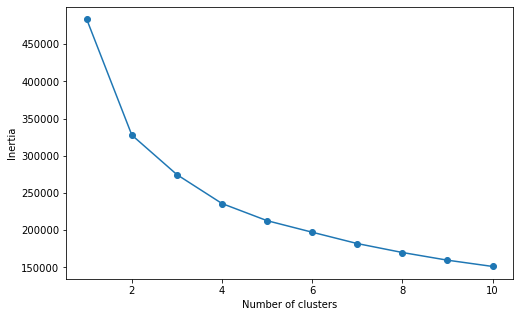

In [71]:
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

scores = []

for k in range(1,11):
    km = KMeans(n_clusters = k,random_state=1)
    km = km.fit(data_transformed)
    scores.append(km.inertia_)

dfk = pd.DataFrame({'Cluster':range(1,11), 'Score':scores})
plt.figure(figsize=(8,5))
plt.plot(dfk['Cluster'], dfk['Score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Silhouette value
The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

In [72]:
for i in range(2,17):
    kmeans_labels=KMeans(n_clusters=i,random_state=1).fit_predict(data_transformed)
    print("Silhouette score for {} clusters k-means : {} ".format(i,metrics.silhouette_score(data_scaled,kmeans_labels, metric='euclidean').round(3)))

Silhouette score for 2 clusters k-means : 0.238 
Silhouette score for 3 clusters k-means : 0.18 
Silhouette score for 4 clusters k-means : 0.181 
Silhouette score for 5 clusters k-means : 0.17 
Silhouette score for 6 clusters k-means : 0.165 
Silhouette score for 7 clusters k-means : 0.159 
Silhouette score for 8 clusters k-means : 0.151 
Silhouette score for 9 clusters k-means : 0.143 
Silhouette score for 10 clusters k-means : 0.144 
Silhouette score for 11 clusters k-means : 0.144 
Silhouette score for 12 clusters k-means : 0.141 
Silhouette score for 13 clusters k-means : 0.134 
Silhouette score for 14 clusters k-means : 0.134 
Silhouette score for 15 clusters k-means : 0.137 
Silhouette score for 16 clusters k-means : 0.133 


#### Davies Bouldin
Average similarity measure of each cluster to its most similar cluster, where similarity is the ratio of distances within the cluster to distances between clusters. The minimum score is zero, and lower values indicate better clustering.

In [73]:
for i in range(2, 17):
    kmeans_labels=KMeans(n_clusters=i,random_state=1).fit_predict(data_transformed)
    print(f'Davies Bouldin Score {i}: {metrics.davies_bouldin_score(data_scaled,kmeans_labels).round(3)}')

Davies Bouldin Score 2: 1.655
Davies Bouldin Score 3: 1.756
Davies Bouldin Score 4: 1.88
Davies Bouldin Score 5: 1.813
Davies Bouldin Score 6: 1.748
Davies Bouldin Score 7: 1.779
Davies Bouldin Score 8: 1.872
Davies Bouldin Score 9: 1.91
Davies Bouldin Score 10: 1.833
Davies Bouldin Score 11: 1.844
Davies Bouldin Score 12: 1.893
Davies Bouldin Score 13: 1.843
Davies Bouldin Score 14: 1.874
Davies Bouldin Score 15: 1.86
Davies Bouldin Score 16: 1.851


In [74]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 3

kmeans = KMeans(role=role,
                instance_count=1,
                instance_type='ml.p2.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)

#### Create formatted, k-means training data
Just as before, you should convert the data_transformed df into a numpy array and then into a RecordSet. This is the required format for passing training data into a KMeans model.

In [75]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = data_transformed.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

In [77]:
%%time

# train kmeans
kmeans.fit(kmeans_formatted_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-06-19 18:15:17 Starting - Starting the training job...
2021-06-19 18:15:18 Starting - Launching requested ML instancesProfilerReport-1624126516: InProgress
......
2021-06-19 18:16:43 Starting - Preparing the instances for training.........
2021-06-19 18:18:10 Downloading - Downloading input data
2021-06-19 18:18:10 Training - Downloading the training image....Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/19/2021 18:18:53 INFO 140720026646336] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kv

#### Deploy the k-means model

In [78]:
%%time
# deploy the model to create a predictor
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.p2.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!CPU times: user 349 ms, sys: 17.8 ms, total: 367 ms
Wall time: 9min 32s


#### Pass in the training data and assign predicted cluster labels
After deploying the model, you can pass in the k-means training data, as a numpy array, and get resultant, predicted cluster labels for each data point.

In [79]:
# get the predicted clusters for all the kmeans training data
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

#### Exploring the resultant clusters
The resulting predictions should give you information about the cluster that each data point belongs to.

In [80]:
# print cluster info for first data point
data_idx = 0

print('Person is: ', data_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

Person is:  0

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 9.490724563598633
    }
  }
}



#### Visualize the distribution of data over clusters
Get the cluster labels for each of our data points (counties) and visualize the distribution of points over each cluster.

In [81]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

In [82]:
# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

0.0    5329
1.0    4941
2.0    4217
Name: 0, dtype: int64


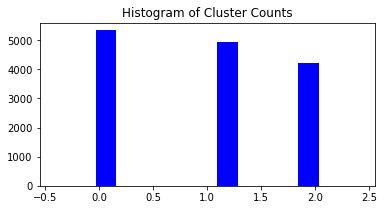

In [83]:
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=8,  range=(-0.5, 2.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

#### Delete the Endpoint!
Now that you've deployed the k-means model and extracted the cluster labels for each data point, you no longer need the k-means endpoint.

In [84]:
# Delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Model Attributes & Explainability
Explaining the result of the modeling is an important step in making use of our analysis. By combining PCA and k-means, and the information contained in the model attributes within a SageMaker trained model, you can learn about a population and remark on some patterns you've found, based on the data.

In [86]:
# Download and unzip the kmeans model file
kmeans_job_name = 'kmeans-2021-06-19-18-15-16-449'

model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

# download the model file
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [87]:

# Get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

[
[[ 2.3058112  -1.9899037  -0.50196165  0.10453863  0.20930876]
 [-4.3760934  -0.44408292  0.36875993 -0.23492788 -0.12042815]
 [ 1.8572959   2.8362374   0.20773415  0.11898171 -0.12316365]]
<NDArray 3x5 @cpu(0)>]


In [88]:
# Get all the centroids
cluster_centroids = pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns = data_transformed.columns

display(cluster_centroids)

,c_1,c_2,c_3,c_4,c_5
0,2.305811,-1.989904,-0.501962,0.104539,0.209309
1,-4.376093,-0.444083,0.368760,-0.234928,-0.120428
2,1.857296,2.836237,0.207734,0.118982,-0.123164


In [90]:
# Save clusteres
cluster_centroids.to_csv('saved_progress/cluster_centroids.csv')

#### Visualizing Centroids in Component Space

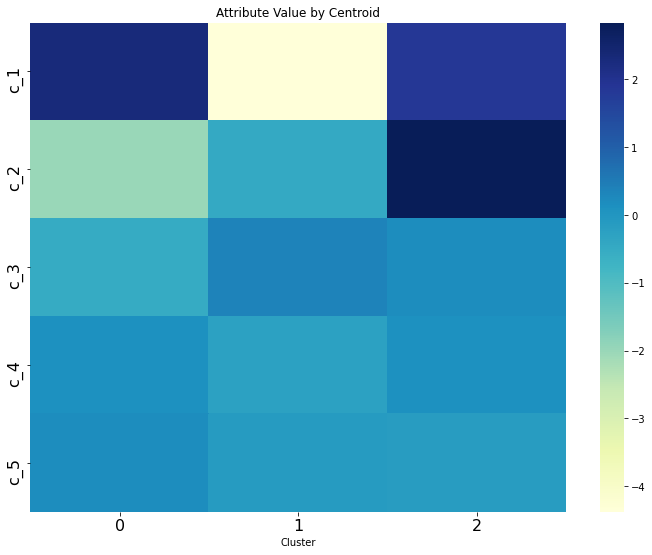

In [91]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

#### Natural Grouping

In [92]:

# add a 'labels' column to the dataframe
data_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_clients = data_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_clients.head(20)

,c_1,c_2,c_3,c_4,c_5,labels
3834,5.914986,-2.451452,-0.638013,-1.840802,0.686617,0
4668,3.279210,-2.140202,0.539204,1.997913,-4.223079,0
4667,1.446168,-2.107751,-0.689240,-0.534639,2.434066,0
10286,0.689152,-1.305663,1.560146,1.393200,3.358397,0
4665,0.956781,-0.848757,-1.953558,1.493148,2.169174,0
4664,-0.288305,-1.160262,1.548514,-1.084404,-0.892948,0
4663,3.658467,-1.215688,-1.183427,-2.189341,2.011821,0
4662,-0.914955,-2.708002,-2.644798,-4.271396,0.300070,0
10288,-0.220405,-2.858996,-0.332667,0.988530,-1.165881,0
4659,1.624834,-0.639665,-3.140638,2.187498,0.039481,0


In [94]:
cluster_centroids.to_csv('saved_progress/kmeans_clusters.csv')

In [95]:
# Get all counties with label == 1
cluster = data_transformed[data_transformed['labels']==1]
cluster.head()

,c_1,c_2,c_3,c_4,c_5,labels
0,-2.620176,-1.928997,-4.023331,7.190509,-3.338821,1
4,-2.118860,-2.629998,-1.038443,0.802769,0.593156,1
6,-5.679704,-1.111900,-3.203012,3.253933,1.779346,1
8,-4.136014,3.675967,-2.232442,-2.868910,0.061204,1
10,-4.430820,3.114770,3.403000,4.401917,-1.578365,1


In [96]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 22.9 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp36-cp36m-linux_x86_64.whl size=2667468 sha256=22b5e7e4382da3eedff25cc61719d2f5968e90636c88049948baa6a3476c9d24
  Stored in directory: /home/ec2-user/.cache/pip/wheels/70/52/fe/83ef5a0e879c48df9968d931d41046226e4cb19a166f0223d2
Successfully built hdbscan


In [99]:
import hdbscan

In [142]:
data = pd.read_csv('saved_progress/scaled_dataset.csv')
data.drop(columns=["Unnamed: 0" ], inplace=True)
data

,gender,income,total_completed,total_viewed,total_received,total_spent,avg_spent,completed_bogo,completed_discount,age_range,num_transactions_range,bogos_received_range,discounts_received_range,percent_viewed_range,percent_completed_range,discount_percent_completed_range,bogo_percent_completed_range
0,0,0.911111,1,0,2,0.047886,0.055432,1,0,4,0,0,0,0,5,0,5
1,0,0.777778,3,4,4,0.098881,0.048780,3,0,6,6,3,0,9,7,0,3
2,1,0.444444,2,3,4,0.035448,0.042129,1,2,5,0,0,3,7,5,4,3
3,1,0.255556,5,6,6,0.022388,0.026608,2,2,5,0,1,3,9,8,3,1
4,1,0.233333,1,2,3,0.009328,0.006652,0,2,4,0,0,3,6,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14482,0,0.266667,0,3,3,0.012438,0.004435,1,1,3,6,0,0,9,0,5,5
14483,1,0.466667,1,1,3,0.015547,0.006652,1,0,5,6,0,0,3,3,0,5
14484,1,0.477778,0,1,3,0.024254,0.008869,0,1,3,6,0,0,3,0,9,5
14485,0,0.222222,3,3,3,0.117537,0.028825,3,0,7,1,3,0,9,9,0,3


In [143]:
data = data.to_numpy()

In [153]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, gen_min_span_tree=True)
clusterer.fit(data)


HDBSCAN(gen_min_span_tree=True, min_cluster_size=25)

<AxesSubplot:>

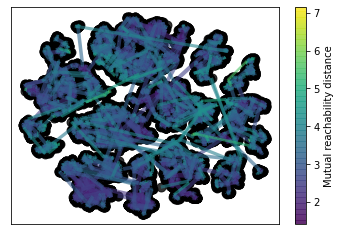

In [154]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=80, 
                                      edge_linewidth=2)

In [155]:
labels = pd.DataFrame(clusterer.labels_)
labels[0].unique()

array([-1,  2,  1,  0,  3])